In [32]:
%cd "C:\Users\lmosquen\Desktop\Python\Proyecto mundial\worldcup-2026-prediction-main\worldcup-2026-prediction-main\notebooks"
import os
os.getcwd()


C:\Users\lmosquen\Desktop\Python\Proyecto mundial\worldcup-2026-prediction-main\worldcup-2026-prediction-main\notebooks


'C:\\Users\\lmosquen\\Desktop\\Python\\Proyecto mundial\\worldcup-2026-prediction-main\\worldcup-2026-prediction-main\\notebooks'

In [33]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import os


In [34]:
import pandas as pd
import numpy as np

# Cargo ratings congelados del Notebook 05
team_features = pd.read_csv("../data/processed/team_features_final.csv")
team_features = team_features.set_index("team")
team_features.head()


,elo,modern_power,market_value,elo_norm,modern_norm,market_norm,final_power
team,,,,,,,
Afghanistan,1033.0,-0.086667,NaN,-1.018456,-1.015353,NaN,NaN
Albania,1664.0,0.254930,NaN,0.803067,-0.050096,NaN,NaN
Algeria,1718.0,0.639744,150.0,0.958951,1.037283,-0.473985,0.843073
Andorra,1083.0,-0.383803,NaN,-0.874120,-1.854979,NaN,NaN
Angola,1566.0,0.392742,NaN,0.520168,0.339324,NaN,NaN


In [35]:
groups_official_raw = {
    "Group A": ["Mexico", "South Africa", "South Korea", "UEFA PO D"],
    "Group B": ["Canada", "UEFA PO A", "Qatar", "Switzerland"],
    "Group C": ["Brazil", "Morocco", "Haiti", "Scotland"],
    "Group D": ["United States", "Paraguay", "Australia", "UEFA PO C"],
    "Group E": ["Germany", "Curaçao", "Ivory Coast", "Ecuador"],
    "Group F": ["Netherlands", "Japan", "UEFA PO B", "Tunisia"],
    "Group G": ["Belgium", "Egypt", "Iran", "New Zealand"],
    "Group H": ["Spain", "Cape Verde", "Saudi Arabia", "Uruguay"],
    "Group I": ["France", "Senegal", "FIFA PO 2", "Norway"],
    "Group J": ["Argentina", "Austria", "Algeria", "Jordan"],
    "Group K": ["Portugal", "FIFA PO 1", "Uzbekistan", "Colombia"],
    "Group L": ["England", "Croatia", "Ghana", "Panama"],
}


In [36]:
name_map = {
    "Korea Republic": "South Korea",
    "Côte d'Ivoire": "Ivory Coast",
    "IR Iran": "Iran",
    "Cabo Verde": "Cape Verde",
    
}

def normalize_team_name(name: str) -> str:
    return name_map.get(name, name)

groups_official = {
    g: [normalize_team_name(t) for t in teams]
    for g, teams in groups_official_raw.items()
}

for g, teams in groups_official.items():
    print(f"{g}: {', '.join(teams)}")


Group A: Mexico, South Africa, South Korea, UEFA PO D
Group B: Canada, UEFA PO A, Qatar, Switzerland
Group C: Brazil, Morocco, Haiti, Scotland
Group D: United States, Paraguay, Australia, UEFA PO C
Group E: Germany, Curaçao, Ivory Coast, Ecuador
Group F: Netherlands, Japan, UEFA PO B, Tunisia
Group G: Belgium, Egypt, Iran, New Zealand
Group H: Spain, Cape Verde, Saudi Arabia, Uruguay
Group I: France, Senegal, FIFA PO 2, Norway
Group J: Argentina, Austria, Algeria, Jordan
Group K: Portugal, FIFA PO 1, Uzbekistan, Colombia
Group L: England, Croatia, Ghana, Panama


In [37]:
# Armo el fixture de grupos
rows = []
for group, teams in groups_official.items():
    for team in teams:
        rows.append({"group": group, "team": team})

df_fixture = pd.DataFrame(rows)
df_fixture["team"] = df_fixture["team"].str.strip()

# Map final_power desde team_features
team_features_clean = team_features.copy()
team_features_clean.index = team_features_clean.index.str.strip()

df_fixture["final_power"] = df_fixture["team"].map(team_features_clean["final_power"])

# Ver NaN (normal que aparezcan los PO)
df_fixture[df_fixture["final_power"].isna()]



,group,team,final_power
3,Group A,UEFA PO D,NaN
5,Group B,UEFA PO A,NaN
15,Group D,UEFA PO C,NaN
22,Group F,UEFA PO B,NaN
34,Group I,FIFA PO 2,NaN
41,Group K,FIFA PO 1,NaN


In [38]:
mask_nan = df_fixture["final_power"].isna()
print("Equipos sin rating:", df_fixture.loc[mask_nan, "team"].tolist())

median_power = df_fixture["final_power"].median(skipna=True)
df_fixture.loc[mask_nan, "final_power"] = median_power

# Confirmo que no haya más NaN
df_fixture[df_fixture["final_power"].isna()]


Equipos sin rating: ['UEFA PO D', 'UEFA PO A', 'UEFA PO C', 'UEFA PO B', 'FIFA PO 2', 'FIFA PO 1']


,group,team,final_power


In [39]:
df_fixture = df_fixture.sort_values(
    ["group", "final_power"],
    ascending=[True, False]
).reset_index(drop=True)

df_fixture.head(30)



,group,team,final_power
0,Group A,Mexico,1.190610
1,Group A,South Korea,1.034537
2,Group A,UEFA PO D,1.027833
3,Group A,South Africa,0.326291
4,Group B,Switzerland,1.154199
5,Group B,UEFA PO A,1.027833
6,Group B,Canada,0.945296
7,Group B,Qatar,0.409104
8,Group C,Brazil,1.724582
9,Group C,Morocco,1.107163


In [40]:
ROUND_FACTOR = {
    "R32": 1.0,
    "R16": 0.85,
    "QF": 0.75,
    "SF": 0.65,
    "Final": 0.60,
}


In [41]:
def expected_goals(power_a: float, power_b: float,
                   base_xg: float = 1.4, beta: float = 0.8):
    diff = power_a - power_b
    factor_a = 1 + beta * diff
    factor_b = 1 - beta * diff

    mu_a = max(0.1, base_xg * factor_a)
    mu_b = max(0.1, base_xg * factor_b)
    return mu_a, mu_b


def win_draw_loss_probs(power_a: float, power_b: float,
                        p_draw: float = 0.20, sharpness: float = 4.0):
    base_pA = power_a / (power_a + power_b)
    base_pB = 1.0 - base_pA

    pa_num = base_pA ** sharpness
    pb_num = base_pB ** sharpness
    pa_sharp = pa_num / (pa_num + pb_num)
    pb_sharp = 1.0 - pa_sharp

    non_draw = 1.0 - p_draw
    pA = pa_sharp * non_draw
    pB = pb_sharp * non_draw

    return pA, p_draw, pB


rng = np.random.default_rng(2026)

def simulate_match(power_a, power_b, rng, round_factor=1.0):
    pA, pD, pB = win_draw_loss_probs(power_a, power_b)

    # 👉 nuevo ajuste por ronda
    pA, pD, pB = apply_round_uncertainty(pA, pD, pB, round_factor)

    outcome = rng.choice(["A", "D", "B"], p=[pA, pD, pB])

    mu_a, mu_b = expected_goals(power_a, power_b)
    ga = rng.poisson(mu_a)
    gb = rng.poisson(mu_b)

    if outcome == "A" and ga <= gb:
        ga = gb + 1
    elif outcome == "B" and gb <= ga:
        gb = ga + 1
    elif outcome == "D":
        g = rng.integers(0, 4)
        ga = gb = g

    if ga > gb:
        pts_a, pts_b = 3, 0
    elif ga < gb:
        pts_a, pts_b = 0, 3
    else:
        pts_a, pts_b = 1, 1

    return ga, gb, pts_a, pts_b

def apply_round_uncertainty(pA, pD, pB, factor):
    # factor entre 0 y 1
    # 1 = sin cambio, 0 = totalmente aleatorio
    pA_adj = 0.5 + (pA - 0.5) * factor
    pB_adj = 0.5 + (pB - 0.5) * factor

    non_draw = pA_adj + pB_adj
    pD_adj = 1.0 - non_draw

    return pA_adj, pD_adj, pB_adj



In [42]:
from itertools import combinations

def get_group_matches(df_fixture: pd.DataFrame):
    rows = []
    for g, sub in df_fixture.groupby("group"):
        teams = sub["team"].tolist()
        for a, b in combinations(teams, 2):
            rows.append({"group": g, "team_a": a, "team_b": b})
    return pd.DataFrame(rows)


def simulate_group_stage_once(df_fixture: pd.DataFrame, rng: np.random.Generator):
    group_matches = get_group_matches(df_fixture)

    stats = (
        df_fixture[["group", "team", "final_power"]]
        .assign(pts=0, gf=0, ga=0, gd=0, matches=0)
        .set_index(["group", "team"])
    )

    for _, row in group_matches.iterrows():
        g = row["group"]
        a = row["team_a"]
        b = row["team_b"]

        pA = df_fixture.loc[(df_fixture["group"] == g) & (df_fixture["team"] == a), "final_power"].iloc[0]
        pB = df_fixture.loc[(df_fixture["group"] == g) & (df_fixture["team"] == b), "final_power"].iloc[0]

        ga, gb, pts_a, pts_b = simulate_match(pA, pB, rng)

        stats.loc[(g, a), "pts"] += pts_a
        stats.loc[(g, b), "pts"] += pts_b

        stats.loc[(g, a), "gf"] += ga
        stats.loc[(g, a), "ga"] += gb
        stats.loc[(g, b), "gf"] += gb
        stats.loc[(g, b), "ga"] += ga

        stats.loc[(g, a), "matches"] += 1
        stats.loc[(g, b), "matches"] += 1

    stats["gd"] = stats["gf"] - stats["ga"]
    stats = stats.reset_index()

    standings_list = []
    for g, sub in stats.groupby("group"):
        sub = sub.copy()
        sub = sub.sort_values(
            by=["pts", "gd", "gf", "final_power"],
            ascending=[False, False, False, False]
        ).reset_index(drop=True)
        sub["position"] = np.arange(1, len(sub) + 1)
        standings_list.append(sub)

    standings = pd.concat(standings_list, ignore_index=True)
    return standings


In [43]:
rng = np.random.default_rng(123)
standings = simulate_group_stage_once(df_fixture, rng)
standings[standings["group"] == "Group J"]


,group,team,final_power,pts,gf,ga,gd,matches,position
36,Group J,Argentina,1.760462,7,5,2,3,3,1
37,Group J,Jordan,0.607177,4,4,5,-1,3,2
38,Group J,Algeria,0.843073,3,4,5,-1,3,3
39,Group J,Austria,0.926376,2,6,7,-1,3,4


In [44]:
def simulate_one_group(df_fixture, group_name, rng):
    sub = df_fixture[df_fixture["group"] == group_name].copy()
    teams = sub["team"].tolist()
    powers = sub.set_index("team")["final_power"].to_dict()

    matches = [
        (teams[i], teams[j])
        for i in range(len(teams))
        for j in range(i+1, len(teams))
    ]

    pts = {t: 0 for t in teams}
    gf  = {t: 0 for t in teams}
    ga  = {t: 0 for t in teams}

    for a, b in matches:
        ga_g, gb_g, pts_a, pts_b = simulate_match(powers[a], powers[b], rng)

        pts[a] += pts_a
        pts[b] += pts_b
        gf[a]  += ga_g
        ga[a]  += gb_g
        gf[b]  += gb_g
        ga[b]  += ga_g

    table = sorted(
        teams,
        key=lambda t: (pts[t], gf[t] - ga[t], gf[t], powers[t]),
        reverse=True
    )

    return table[0]


def simulate_group_many_fast(df_fixture, group_name, n=2000):
    rng = np.random.default_rng(123)
    counts = {}
    for _ in range(n):
        first = simulate_one_group(df_fixture, group_name, rng)
        counts[first] = counts.get(first, 0) + 1
    return counts

simulate_group_many_fast(df_fixture, "Group J", n=2000)


{'Argentina': 1722, 'Austria': 178, 'Algeria': 83, 'Jordan': 17}

In [45]:
def rank_third_places_from_standings(standings: pd.DataFrame):
    """
    Ordena los 12 terceros según criterios tipo FIFA:
    puntos, diferencia de gol, goles a favor, final_power.
    Devuelve:
      - todos los terceros con columna 'third_rank'
      - los 8 mejores terceros (los que pasan a R32)
    """
    thirds = standings[standings["position"] == 3].copy()
    thirds = thirds.sort_values(
        by=["pts", "gd", "gf", "final_power"],
        ascending=[False, False, False, False]
    ).reset_index(drop=True)
    thirds["third_rank"] = np.arange(1, len(thirds) + 1)
    best_thirds = thirds.head(8).copy()
    return thirds, best_thirds


def get_qualified_32_from_standings(standings: pd.DataFrame):
    """
    Devuelve un DataFrame con los 32 clasificados:
    1º, 2º de cada grupo + 8 mejores terceros.
    """
    # 1º y 2º de cada grupo
    firsts = standings[standings["position"] == 1].copy()
    seconds = standings[standings["position"] == 2].copy()

    firsts["qual_type"] = "1st"
    seconds["qual_type"] = "2nd"

    # Mejores terceros
    _, best_thirds = rank_third_places_from_standings(standings)
    best_thirds["qual_type"] = "3rd"

    qualified_32 = pd.concat([firsts, seconds, best_thirds], ignore_index=True)

    # Extraigo la letra del grupo (A, B, ..., L)
    qualified_32["group_letter"] = qualified_32["group"].str.split().str[-1]

    # Me quedo con lo más importante
    qualified_32 = qualified_32[
        ["team", "group", "group_letter", "final_power", "qual_type", "pts", "gd", "gf"]
    ]

    return qualified_32


In [46]:
rng = np.random.default_rng(2026)
standings = simulate_group_stage_once(df_fixture, rng)
qualified_32 = get_qualified_32_from_standings(standings)

qualified_32.head(20)
qualified_32["qual_type"].value_counts()


qual_type
1st    12
2nd    12
3rd     8
Name: count, dtype: int64

In [47]:
# Especificaciones de los partidos que llevan terceros (según FIFA)
THIRD_SLOTS = [
    {"match_id": 74, "winner_group": "E", "candidate_groups": ["A", "B", "C", "D", "F"]},
    {"match_id": 77, "winner_group": "I", "candidate_groups": ["C", "D", "F", "G", "H"]},
    {"match_id": 79, "winner_group": "A", "candidate_groups": ["C", "E", "F", "H", "I"]},
    {"match_id": 80, "winner_group": "L", "candidate_groups": ["E", "H", "I", "J", "K"]},
    {"match_id": 81, "winner_group": "D", "candidate_groups": ["B", "E", "F", "I", "J"]},
    {"match_id": 82, "winner_group": "G", "candidate_groups": ["A", "E", "H", "I", "J"]},
    {"match_id": 85, "winner_group": "B", "candidate_groups": ["E", "F", "G", "I", "J"]},
    {"match_id": 87, "winner_group": "K", "candidate_groups": ["D", "E", "I", "J", "L"]},
]


In [48]:
def assign_third_groups(best_thirds: pd.DataFrame):
    """
    best_thirds: DataFrame con columnas 'team', 'group_letter', 'third_rank'
    Devuelve un dict: match_id -> group_letter del tercer clasificado usado en ese match.
    Siempre usa cada grupo de third una sola vez.
    """
    # Conjunto de grupos que efectivamente aportan tercero (ej: {"A","C","D","F","G","I","J","K"})
    third_groups = sorted(best_thirds["group_letter"].unique())

    # Preparo para cada slot las opciones que intersectan con los grupos disponibles
    slot_options = []
    for slot in THIRD_SLOTS:
        cand = [g for g in slot["candidate_groups"] if g in third_groups]
        slot_options.append({
            "match_id": slot["match_id"],
            "winner_group": slot["winner_group"],
            "candidate_groups": cand,
        })

    # Ordeno los slots por "difícil": menos opciones primero, para que el backtracking sea más eficiente
    slot_options.sort(key=lambda s: len(s["candidate_groups"]))

    assignment = {}         # match_id -> group_letter
    used_groups = set()     # grupos ya usados (cada grupo solo una vez)

    def backtrack(i):
        if i == len(slot_options):
            return True  

        slot = slot_options[i]
        mid = slot["match_id"]
        for g in slot["candidate_groups"]:
            if g in used_groups:
                continue
            
            used_groups.add(g)
            assignment[mid] = g
            if backtrack(i + 1):
                return True
            # backtrack
            used_groups.remove(g)
            del assignment[mid]

        return False

    if not backtrack(0):
        raise ValueError(f"No se pudo encontrar una asignación válida de terceros con grupos {third_groups}")

    return assignment


In [49]:
def build_official_r32_bracket(qualified_32: pd.DataFrame, standings: pd.DataFrame):
    """
    Construye el cuadro de 32avos usando:
      - 1º y 2º de cada grupo (de 'qualified_32')
      - 8 mejores terceros (de 'standings')
      - estructura oficial FIFA 2026 para R32,
        con asignación de terceros mediante backtracking.
    """
    # Mapas rápidos de ganadores y segundos
    winners = (
        qualified_32[qualified_32["qual_type"] == "1st"]
        .set_index("group_letter")["team"]
        .to_dict()
    )
    runners = (
        qualified_32[qualified_32["qual_type"] == "2nd"]
        .set_index("group_letter")["team"]
        .to_dict()
    )

    # Ranking de terceros
    thirds_all, best_thirds = rank_third_places_from_standings(standings)
    best_thirds["group_letter"] = best_thirds["group"].str.split().str[-1]

    # Asignación de grupos a cada partido con tercero
    assignment = assign_third_groups(best_thirds)  # match_id -> group_letter

    # Helper para traer el team según group_letter
    def get_third_team_from_group(gl):
        row = best_thirds[best_thirds["group_letter"] == gl].iloc[0]
        return row["team"]

    matches = []

    # M73 – A2 vs B2 (solo segundos)
    matches.append({"match_id": 73, "round": "R32",
                    "team_a": runners["A"], "team_b": runners["B"]})

    # M74 – E1 vs 3º (A/B/C/D/F)
    g_74 = assignment[74]
    matches.append({"match_id": 74, "round": "R32",
                    "team_a": winners["E"], "team_b": get_third_team_from_group(g_74)})

    # M75 – F1 vs C2
    matches.append({"match_id": 75, "round": "R32",
                    "team_a": winners["F"], "team_b": runners["C"]})

    # M76 – C1 vs F2
    matches.append({"match_id": 76, "round": "R32",
                    "team_a": winners["C"], "team_b": runners["F"]})

    # M77 – I1 vs 3º (C/D/F/G/H)
    g_77 = assignment[77]
    matches.append({"match_id": 77, "round": "R32",
                    "team_a": winners["I"], "team_b": get_third_team_from_group(g_77)})

    # M78 – E2 vs I2
    matches.append({"match_id": 78, "round": "R32",
                    "team_a": runners["E"], "team_b": runners["I"]})

    # M79 – A1 vs 3º (C/E/F/H/I)
    g_79 = assignment[79]
    matches.append({"match_id": 79, "round": "R32",
                    "team_a": winners["A"], "team_b": get_third_team_from_group(g_79)})

    # M80 – L1 vs 3º (E/H/I/J/K)
    g_80 = assignment[80]
    matches.append({"match_id": 80, "round": "R32",
                    "team_a": winners["L"], "team_b": get_third_team_from_group(g_80)})

    # M81 – D1 vs 3º (B/E/F/I/J)
    g_81 = assignment[81]
    matches.append({"match_id": 81, "round": "R32",
                    "team_a": winners["D"], "team_b": get_third_team_from_group(g_81)})

    # M82 – G1 vs 3º (A/E/H/I/J)
    g_82 = assignment[82]
    matches.append({"match_id": 82, "round": "R32",
                    "team_a": winners["G"], "team_b": get_third_team_from_group(g_82)})

    # M83 – K2 vs L2
    matches.append({"match_id": 83, "round": "R32",
                    "team_a": runners["K"], "team_b": runners["L"]})

    # M84 – H1 vs J2
    matches.append({"match_id": 84, "round": "R32",
                    "team_a": winners["H"], "team_b": runners["J"]})

    # M85 – B1 vs 3º (E/F/G/I/J)
    g_85 = assignment[85]
    matches.append({"match_id": 85, "round": "R32",
                    "team_a": winners["B"], "team_b": get_third_team_from_group(g_85)})

    # M86 – J1 vs H2
    matches.append({"match_id": 86, "round": "R32",
                    "team_a": winners["J"], "team_b": runners["H"]})

    # M87 – K1 vs 3º (D/E/I/J/L)
    g_87 = assignment[87]
    matches.append({"match_id": 87, "round": "R32",
                    "team_a": winners["K"], "team_b": get_third_team_from_group(g_87)})

    # M88 – D2 vs G2
    matches.append({"match_id": 88, "round": "R32",
                    "team_a": runners["D"], "team_b": runners["G"]})

    r32 = pd.DataFrame(matches).sort_values("match_id").reset_index(drop=True)
    return r32



In [50]:
rng = np.random.default_rng(123)

standings = simulate_group_stage_once(df_fixture, rng)
qualified_32 = get_qualified_32_from_standings(standings)

r32 = build_official_r32_bracket(qualified_32, standings)
r32



,match_id,round,team_a,team_b
0,73,R32,Mexico,Switzerland
1,74,R32,Germany,South Korea
2,75,R32,Netherlands,Morocco
3,76,R32,Brazil,Japan
4,77,R32,France,Scotland
5,78,R32,Ecuador,FIFA PO 2
6,79,R32,UEFA PO D,Saudi Arabia
7,80,R32,England,Senegal
8,81,R32,United States,Canada
9,82,R32,New Zealand,Algeria


In [63]:
def simulate_match_knockout(
    power_a: float,
    power_b: float,
    rng: np.random.Generator,
    round_factor: float = 1.0
):
    """
    Simula un partido de eliminación directa con incertidumbre por ronda.
    """

    # 👉 Compresión de poder en KO
    adj_pa = 0.5 + (power_a - 0.5) * round_factor
    adj_pb = 0.5 + (power_b - 0.5) * round_factor

    # Probabilidades sin empate
    pA, _, pB = win_draw_loss_probs(adj_pa, adj_pb, p_draw=0.0)

    # Goles esperados (AFECTADOS por el factor)
    mu_a, mu_b = expected_goals(adj_pa, adj_pb)
    ga = rng.poisson(mu_a)
    gb = rng.poisson(mu_b)

    if ga == gb:
        winner_flag = rng.choice(["A", "B"], p=[pA, pB])
        if winner_flag == "A":
            ga += 1
        else:
            gb += 1
    else:
        winner_flag = "A" if ga > gb else "B"

    return winner_flag, ga, gb


In [64]:
def play_knockout_round(bracket_df: pd.DataFrame,
                        powers: dict,
                        rng: np.random.Generator,
                        next_round_name: str):
    """
    Toma un DataFrame con columnas:
      ['match_id', 'round', 'team_a', 'team_b']
    Juega los partidos y devuelve:
      - next_bracket: DataFrame de la siguiente ronda
      - winners: lista de ganadores en orden
    """
    winners = []
    rows_next = []

    # Ordeno por match_id para que el emparejamiento sea consistente
    bracket_df = bracket_df.sort_values("match_id")

    for _, row in bracket_df.iterrows():
        a = row["team_a"]
        b = row["team_b"]

        pa = powers[a]
        pb = powers[b]

        # 👉 CLAVE: factor según la ronda actual
        round_name = row["round"]
        rf = ROUND_FACTOR.get(round_name, 1.0)

        # 👉 CLAVE: pasamos el round_factor
        w_flag, ga, gb = simulate_match_knockout(
            pa, pb, rng, round_factor=rf
        )

        winner = a if w_flag == "A" else b
        winners.append(winner)

    # Emparejo ganadores de a pares para la próxima ronda
    next_match_id_base = bracket_df["match_id"].max() + 1
    m_id = next_match_id_base

    for i in range(0, len(winners), 2):
        rows_next.append({
            "match_id": m_id,
            "round": next_round_name,
            "team_a": winners[i],
            "team_b": winners[i + 1],
        })
        m_id += 1

    next_bracket = pd.DataFrame(rows_next)
    return next_bracket, winners


In [65]:
def simulate_worldcup_once(df_fixture: pd.DataFrame, rng: np.random.Generator):
    # 1) Fase de grupos
    standings = simulate_group_stage_once(df_fixture, rng)

    # 2) 32 clasificados
    qualified_32 = get_qualified_32_from_standings(standings)

    # 3) R32 oficial
    r32 = build_official_r32_bracket(qualified_32, standings)

    # Diccionario de poderes
    powers = df_fixture.set_index("team")["final_power"].to_dict()

    # 4) R32 -> R16
    r16, w32 = play_knockout_round(r32, powers, rng, next_round_name="R16")

    # 5) R16 -> QF
    qf, w16 = play_knockout_round(r16, powers, rng, next_round_name="QF")

    # 6) QF -> SF
    sf, w8 = play_knockout_round(qf, powers, rng, next_round_name="SF")

    # 7) SF -> Final
    final_bracket, w4 = play_knockout_round(sf, powers, rng, next_round_name="Final")

    # 8) Final -> campeón (un solo partido)
    final_row = final_bracket.iloc[0]
    a = final_row["team_a"]
    b = final_row["team_b"]

    pa = powers[a]
    pb = powers[b]

    w_flag, ga, gb = simulate_match_knockout(pa, pb, rng)
    champion = a if w_flag == "A" else b

    return {
        "standings": standings,
        "qualified_32": qualified_32,
        "r32": r32,
        "r16": r16,
        "qf": qf,
        "sf": sf,
        "final": final_bracket,
        "champion": champion,
    }


In [66]:
rng = np.random.default_rng(2026)
result = simulate_worldcup_once(df_fixture, rng)

result["champion"], result["final"]


('Argentina',
    match_id  round  team_a     team_b
 0       103  Final  Brazil  Argentina)

In [67]:
from itertools import combinations

groups_struct = {}

for g, sub in df_fixture.groupby("group"):
    teams = sub["team"].tolist()
    powers = sub.set_index("team")["final_power"].to_dict()
    matches = list(combinations(teams, 2))  # 6 partidos por grupo
    groups_struct[g] = {
        "teams": teams,
        "powers": powers,
        "matches": matches,
    }

groups_struct.keys()


dict_keys(['Group A', 'Group B', 'Group C', 'Group D', 'Group E', 'Group F', 'Group G', 'Group H', 'Group I', 'Group J', 'Group K', 'Group L'])

In [68]:
def simulate_group_stage_fast(groups_struct, rng):
    
    rows = []

    for g, info in groups_struct.items():
        teams   = info["teams"]
        powers  = info["powers"]
        matches = info["matches"]

        pts = {t: 0 for t in teams}
        gf  = {t: 0 for t in teams}
        ga  = {t: 0 for t in teams}

        for a, b in matches:
            ga_g, gb_g, pts_a, pts_b = simulate_match(powers[a], powers[b], rng)

            pts[a] += pts_a
            pts[b] += pts_b
            gf[a]  += ga_g
            ga[a]  += gb_g
            gf[b]  += gb_g
            ga[b]  += ga_g

        for t in teams:
            rows.append({
                "group": g,
                "team": t,
                "final_power": powers[t],
                "pts": pts[t],
                "gf": gf[t],
                "ga": ga[t],
                "gd": gf[t] - ga[t],
            })

    standings = pd.DataFrame(rows)

    # Orden por grupo 
    standings_list = []
    for g, sub in standings.groupby("group"):
        sub = sub.sort_values(
            by=["pts", "gd", "gf", "final_power"],
            ascending=[False, False, False, False]
        ).reset_index(drop=True)
        sub["position"] = np.arange(1, len(sub) + 1)
        standings_list.append(sub)

    standings_sorted = pd.concat(standings_list, ignore_index=True)
    return standings_sorted


In [69]:
rng = np.random.default_rng(123)
standings_fast = simulate_group_stage_fast(groups_struct, rng)
standings_fast.head()


,group,team,final_power,pts,gf,ga,gd,position
0,Group A,UEFA PO D,1.027833,6,9,6,3,1
1,Group A,Mexico,1.190610,5,4,3,1,2
2,Group A,South Korea,1.034537,4,3,3,0,3
3,Group A,South Africa,0.326291,1,2,6,-4,4
4,Group B,UEFA PO A,1.027833,7,7,5,2,1


In [70]:
def simulate_worldcup_once_fast(df_fixture: pd.DataFrame,
                                groups_struct: dict,
                                rng: np.random.Generator):
    # 1) Fase de grupos (rápida)
    standings = simulate_group_stage_fast(groups_struct, rng)

    # 2) 32 clasificados
    qualified_32 = get_qualified_32_from_standings(standings)

    # 3) R32 oficial
    r32 = build_official_r32_bracket(qualified_32, standings)

    powers = df_fixture.set_index("team")["final_power"].to_dict()

    # 4) R32 -> R16
    r16, w32 = play_knockout_round(r32, powers, rng, next_round_name="R16")
    # 5) R16 -> QF
    qf, w16 = play_knockout_round(r16, powers, rng, next_round_name="QF")
    # 6) QF -> SF
    sf, w8 = play_knockout_round(qf, powers, rng, next_round_name="SF")
    # 7) SF -> Final
    final_bracket, w4 = play_knockout_round(sf, powers, rng, next_round_name="Final")

    final_row = final_bracket.iloc[0]
    a = final_row["team_a"]
    b = final_row["team_b"]

    pa = powers[a]
    pb = powers[b]
    w_flag, ga, gb = simulate_match_knockout(pa, pb, rng)
    champion = a if w_flag == "A" else b

    return champion


In [71]:
def monte_carlo_champions_fast(df_fixture: pd.DataFrame,
                               groups_struct: dict,
                               n_sim: int = 1000):
    rng = np.random.default_rng(2026)
    counts = {}

    for i in range(n_sim):
        champ = simulate_worldcup_once_fast(df_fixture, groups_struct, rng)
        counts[champ] = counts.get(champ, 0) + 1

    results = (
        pd.DataFrame(
            [{"team": t, "count": c, "prob_campeon": c / n_sim}
             for t, c in counts.items()]
        )
        .sort_values("prob_campeon", ascending=False)
        .reset_index(drop=True)
    )

    return results


In [72]:
results_5000 = monte_carlo_champions_fast(df_fixture, groups_struct, n_sim=5000)
results_5000.head(20)


,team,count,prob_campeon
0,Spain,1855,0.3710
1,England,784,0.1568
2,France,509,0.1018
3,Argentina,477,0.0954
4,Portugal,364,0.0728
5,Germany,331,0.0662
6,Brazil,268,0.0536
7,Netherlands,236,0.0472
8,Belgium,47,0.0094
9,Japan,41,0.0082


In [73]:
def monte_carlo_paths_fast(df_fixture, groups_struct, n_sim=1000):
    teams = df_fixture["team"].unique().tolist()
    stages = ["R32", "R16", "QF", "SF", "F", "Champion"]

    counts = {t: {s: 0 for s in stages} for t in teams}

    rng = np.random.default_rng(2026)

    for _ in range(n_sim):
        # 1) Fase de grupos
        standings = simulate_group_stage_fast(groups_struct, rng)
        qualified_32 = get_qualified_32_from_standings(standings)
        r32 = build_official_r32_bracket(qualified_32, standings)
        powers = df_fixture.set_index("team")["final_power"].to_dict()

        # R32: todos los que están en el bracket llegan a R32
        for t in pd.unique(r32[["team_a", "team_b"]].values.ravel("K")):
            counts[t]["R32"] += 1

        # R32 -> R16
        r16, w32 = play_knockout_round(r32, powers, rng, next_round_name="R16")
        for t in w32:
            counts[t]["R16"] += 1

        # R16 -> QF
        qf, w16 = play_knockout_round(r16, powers, rng, next_round_name="QF")
        for t in w16:
            counts[t]["QF"] += 1

        # QF -> SF
        sf, w8 = play_knockout_round(qf, powers, rng, next_round_name="SF")
        for t in w8:
            counts[t]["SF"] += 1

        # SF -> Final
        final_bracket, w4 = play_knockout_round(sf, powers, rng, next_round_name="Final")
        for t in w4:
            counts[t]["F"] += 1

        # Final -> Campeón
        final_row = final_bracket.iloc[0]
        a = final_row["team_a"]
        b = final_row["team_b"]

        pa = powers[a]
        pb = powers[b]
        w_flag, ga, gb = simulate_match_knockout(pa, pb, rng)
        champ = a if w_flag == "A" else b
        counts[champ]["Champion"] += 1

    # Paso a DataFrame
    rows = []
    for t in teams:
        row = {"team": t}
        for s in stages:
            row[f"p_{s}"] = counts[t][s] / n_sim
        rows.append(row)

    df_paths = pd.DataFrame(rows)
    df_paths = df_paths.sort_values("p_Champion", ascending=False).reset_index(drop=True)
    return df_paths


In [74]:
df_paths = monte_carlo_paths_fast(df_fixture, groups_struct, n_sim=5000)
df_paths.head(10)


,team,p_R32,p_R16,p_QF,p_SF,p_F,p_Champion
0,Spain,0.9970,0.9240,0.7752,0.6910,0.5028,0.3710
1,England,0.9930,0.9156,0.7366,0.4900,0.3034,0.1568
2,France,0.9796,0.8914,0.7506,0.4080,0.2328,0.1018
3,Argentina,0.9948,0.7892,0.6608,0.4314,0.1846,0.0954
4,Portugal,0.9784,0.8214,0.6096,0.3452,0.1514,0.0728
5,Germany,0.9958,0.8634,0.6804,0.3594,0.1744,0.0662
6,Brazil,0.9946,0.6858,0.4312,0.2718,0.1356,0.0536
7,Netherlands,0.9726,0.7182,0.4204,0.2554,0.1206,0.0472
8,Belgium,0.9422,0.6652,0.3776,0.1100,0.0334,0.0094
9,Japan,0.9276,0.4694,0.1844,0.0810,0.0298,0.0082


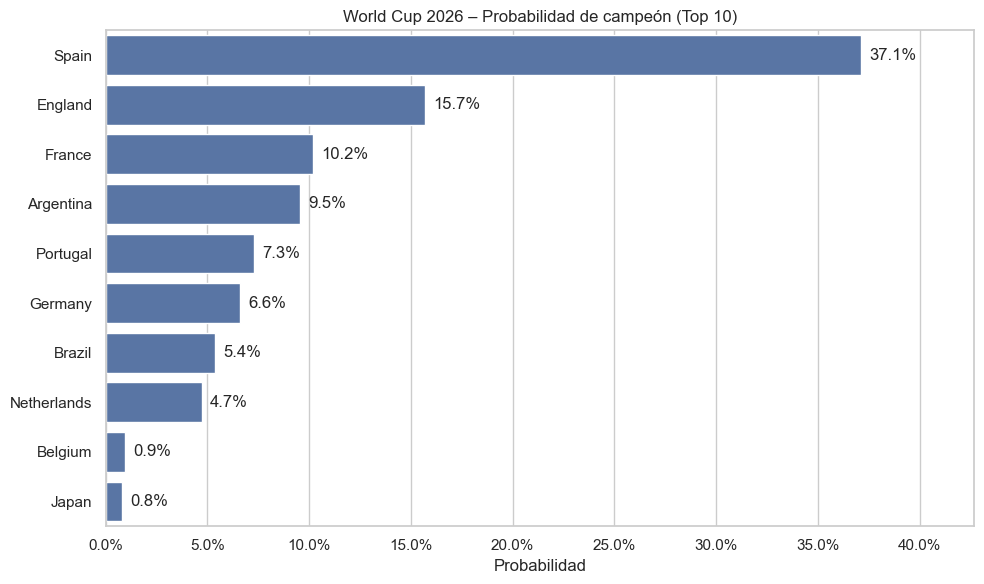

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


df_plot = df_paths.copy()  

top_n = 10
df_top = (
    df_plot.sort_values("p_Champion", ascending=False)
           .head(top_n)
           .copy()
)

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_top,
    y="team",
    x="p_Champion",
    orient="h"
)

ax.set_title(f"World Cup 2026 – Probabilidad de campeón (Top {top_n})")
ax.set_xlabel("Probabilidad")
ax.set_ylabel("")

ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlim(0, df_top["p_Champion"].max() * 1.15)

# Etiquetas de porcentaje al final de cada barra
for p in ax.patches:
    value = p.get_width()
    ax.annotate(
        f"{value*100:.1f}%",
        (value, p.get_y() + p.get_height()/2),
        va="center",
        ha="left",
        xytext=(6, 0),
        textcoords="offset points"
    )

plt.tight_layout()

plt.savefig("top10_champion_probs.png", dpi=200, bbox_inches="tight")

plt.show()
